In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import networkx as nx

from opt_utils import *
from linalg_utils import *

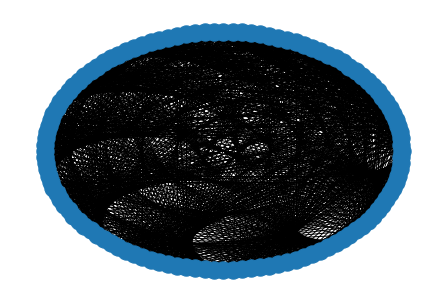

In [2]:
graph_file = "johnson16-2-4.mtx"
graph_type = 1

G = nx.complement(load_graph(graph_file, graph_type))
n = len(G)
nx.draw(G, nx.circular_layout(G))


## Lovasz

In [3]:
prob_lovasz, Z = lovasz_sdp(G)

5.333333334294322


In [4]:
Z_val = remove_small_eigenvalues(Z.value)

In [5]:
Z_center = 1 / n * np.eye(n)

### Fixed point iteration

In [7]:
# fixed_point_iteration(prob_lovasz, Z, -Z_center)

# Z_fixed_point = Z.value
# Z.value = Z_val

In [8]:
# try:
#     Z_vec = recover_incidence_vector(Z_fixed_point, "lovasz")
#     nx.draw(G, nx.circular_layout(G), node_color=Z_vec)
# except:
#     print("recovery failed")

recovery failed


## Grotschel

In [9]:
prob_grotschel, X, x, X_plus = grotschel_sdp(G)

5.333333333275599


In [10]:
X_val = remove_small_eigenvalues(X.value)
x_val = x.value

In [11]:
prob_center_grotschel = cp.Problem(cp.Maximize(cp.log_det(X_plus)), prob_grotschel.constraints)

prob_center_grotschel.solve()

# X_center = X.value
X_center = X_plus.value

X.value = X_val
x.value = x_val

### Fixed point iteration

In [14]:
# fixed_point_iteration(prob_grotschel, X, -X_center)
fixed_point_iteration(prob_grotschel, X_plus, -X_center)

X_fixed_point = X.value
X_plus_fixed_point = X_plus.value
X.value = X_val
x.value = x_val

In [15]:
try:
    X_vec = recover_incidence_vector(X_fixed_point, "grotschel")
    nx.draw(G, nx.circular_layout(G), node_color=X_vec)
except:
    print("recovery failed")

recovery failed


## Benson & Ye

In [3]:
prob_benson, V = benson_sdp(G)

7.999998342999302


In [4]:
V_val = remove_small_eigenvalues(V.value)

In [5]:
prob_center_benson = cp.Problem(cp.Maximize(cp.log_det(V)), prob_benson.constraints)

prob_center_benson.solve()

V_center = V.value
V.value = V_val

Error: rescode.err_space(1051): Out of space.

### Fixed point iteration

In [ ]:
# fixed_point_iteration(prob_benson, V, -V_center)
fixed_point_iteration(prob_benson, V)

V_fixed_point = V.value
V.value = V_val

In [ ]:
try:
    V_vec = recover_incidence_vector(V_fixed_point, "benson")
    nx.draw(G, nx.circular_layout(G), node_color=V_vec)
except:
    print("recovery failed")

### Hyperplane rounding

In [25]:
benson_cost_mat = np.block([[0.5 * np.eye(n), np.array([[0.25]] * n)], [np.array([[0.25]] * n).T, 0]])
benson_cost = lambda v : np.trace(benson_cost_mat @ np.outer(v, v))

max_cost = -np.Inf
max_v = None
for i in range(100):
    _, v = hyperplane_rounding(decompose_psd(V_val), benson_cost, n_iter=1)
    for (i,j) in G.edges:
        if np.abs(v[i] + v[j] + v[n]) != 1:
            if np.abs(v[i] - v[n]) > np.abs(v[j] - v[n]):
                v[i] = -v[i]
            else:
                v[j] = -v[j]
    current_cost = benson_cost(v)
    if current_cost > max_cost:
        max_cost = current_cost
        max_v = v

max_v *= max_v[n]
max_v = max_v[0:-1]

In [26]:
max_cost

4.0

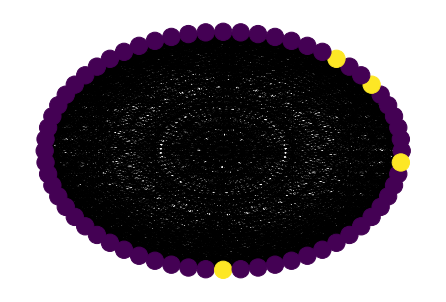

In [27]:
nx.draw(G, nx.circular_layout(G), node_color=max_v)

## Gruber & Rendl greedy algorithm

In [29]:
greedy_z = greedy_stable_set_rounding(Z_val, G)
np.sum(greedy_z)

4.0

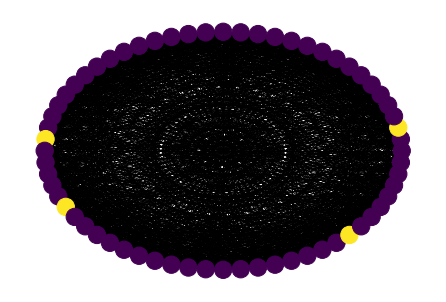

In [30]:
nx.draw(G, nx.circular_layout(G), node_color=greedy_z)

In [31]:
greedy_x = greedy_stable_set_rounding(X_val, G)
np.sum(greedy_x)

4.0

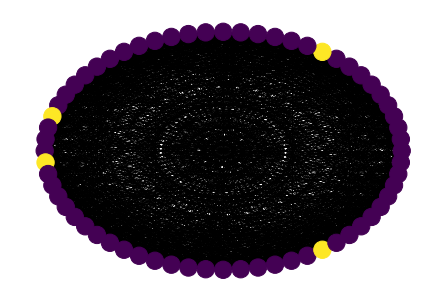

In [32]:
nx.draw(G, nx.circular_layout(G), node_color=greedy_x)

In [33]:
len(nx.maximal_independent_set(G))

2